<a href="https://colab.research.google.com/github/kangmg/personal_study/blob/main/catalyst_research_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time

# %pip install -q git+https://github.com/microsoft/mattersim.git
# %pip install -q git+https://github.com/MDIL-SNU/SevenNet.git
# %pip install -q git+https://github.com/u1234x1234/pynanoflann.git
# %pip install -q orb-models
# %pip install -q git+https://github.com/ACEsuit/mace.git

%pip install -q ase
%pip install -q py3Dmol
%pip install -q torch-dftd

# model ckpt
!mkdir ./models
!wget -q https://github.com/qiqb-osaka/mace-osaka24/releases/download/v0.0.1/mace-osaka24-large.model -O ./models/mace_osaka.pt
!wget -q https://github.com/ACEsuit/mace-mp/releases/download/mace_mpa_0/mace-mpa-0-medium.model -O ./models/mace_mpa_0.pt
!wget -q https://github.com/microsoft/mattersim/raw/refs/heads/main/pretrained_models/mattersim-v1.0.0-5M.pth -O ./models/mattersim_5M.pt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.7/681.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 32.6 MB/s eta 0:00:00
./models/mace_osaka.pt: No such file or directory
./models/mace_mpa_0.pt: No such file or directory
./models/mattersim_5M.pt: No such file or directory
CPU times: user 364 ms, sys: 54.3 ms, total: 419 ms
Wall 

In [2]:
#@title requirement.txt
%%writefile requirements.txt
git+https://github.com/FAIR-Chem/fairchem.git@omat24#subdirectory=packages/fairchem-core
torch_geometric==2.6.1
-f https://data.pyg.org/whl/torch-2.4.0+cpu.html
# torch_scatter==2.1.2 # installation guide
torch_scatter
-f https://data.pyg.org/whl/torch-2.4.0+cu121.html # for gpu usage
torch_sparse==0.6.18
torch_cluster==1.6.3
torch==2.4.1
numpy==1.26.4
ase==3.23.0

Writing requirements.txt


In [3]:
#@title Fairchem

install_fairchem = False # @param ["True","False"] {"type":"raw"}

if install_fairchem:
    %pip install -q -r requirements.txt

    from fairchem.core.common.relaxation.ase_utils import OCPCalculator
    from fairchem.core.models.model_registry import model_name_to_local_file

    checkpoint_path = model_name_to_local_file('EquiformerV2-lE4-lF100-S2EFS-OC22', local_cache='/tmp/fairchem_checkpoints/')
    calc_eqV2 = OCPCalculator(checkpoint_path=checkpoint_path, cpu=False)

    calc_dict = {
        'eqV2': calc_eqV2,
    }

In [8]:
#@title install model

##########################
#    install calcaulator    #
##########################

model = 'mace' #@param ["orb", "mace", "mattersim", "seven", "gfn2", "None"]

AVAILABLE_MODEL = ['orb', 'mace', 'mattersim', 'seven', 'gfn2', 'None']
assert model in AVAILABLE_MODEL, f'model must be one of {AVAILABLE_MODEL}'

if model in AVAILABLE_MODEL:
    if not model == 'gfn2':
        import torch
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

if model == 'orb':
    %pip install -q orb-models
    %pip install -q git+https://github.com/u1234x1234/pynanoflann.git
elif model == 'mace':
    %pip install -q git+https://github.com/ACEsuit/mace.git
elif model == 'mattersim':
    %pip install -q git+https://github.com/microsoft/mattersim.git
elif model == 'seven':
    %pip install -q git+https://github.com/MDIL-SNU/SevenNet.git
elif model == 'gfn2':
    try:
        import tblite
    except:
        # install tblite & conda
        try:
            import condacolab
            condacolab.install()
        except:
            %pip install condacolab
            import condacolab
            condacolab.install()
        !mamba install tblite -y
        !mamba install tblite-python -y
elif model == 'None':
    pass

##########################
#    load calcaulator    #
##########################

if model == 'orb':
    from orb_models.forcefield import pretrained
    from orb_models.forcefield.calculator import ORBCalculator

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    orbff = pretrained.orb_d3_v2(device=device, )
    calc_orb = ORBCalculator(orbff, device=device, )
    calc_dict = {
        'orb': calc_orb,
    }

elif model == 'mace':
    from mace.calculators import mace_mp
    from mace.calculators import MACECalculator

    osaka_path = './models/mace_osaka.pt'
    mace_mpa = "./models/mace_mpa_0.pt"

    calc_mace_mp = mace_mp(model="large", dispersion=True, default_dtype="float64", device=device,)
    calc_mace_mpa = mace_mp(model=mace_mpa, dispersion=True, default_dtype="float64", device=device)
    calc_osaka = MACECalculator(model_path=osaka_path, default_dtype="float64", device=device, )
    calc_dict = {
        'mace_mp': calc_mace_mp,
        'mace_mpa': calc_mace_mpa,
        'mace_osaka': calc_osaka,
    }
elif model == 'mattersim':
    from mattersim.forcefield import MatterSimCalculator

    mattersim_path = './models/mattersim_5M.pt'
    calc_mattersim = MatterSimCalculator(load_path=mattersim_path, device=device)
    calc_dict = {
        'mattersim': calc_mattersim,
    }
elif model == 'seven':
    from sevenn.sevennet_calculator import SevenNetCalculator

    calc_seven = SevenNetCalculator(model='7net-l3i5', device=device)
    calc_dict = {
        'seven': calc_seven,
    }

elif model == 'gfn2':
    from tblite.ase import TBLite
    calc_gfn2 = TBLite(method='GFN2-xTB', charge=0, multiplicity=1)
    calc_dict = {
        'gfn2': calc_gfn2
    }

elif model == 'None':
    pass

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using Materials Project MACE for MACECalculator with /root/.cache/mace/MACE_MPtrj_20229model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


In [9]:
#@title sub calculator
sub_calc = 'None' # @param ["orb", "mace", "mattersim", "seven", 'None']

AVAILABLE_SUB = ['orb', 'mace', 'mattersim', 'seven', 'None']

assert sub_calc in AVAILABLE_SUB, f'model must be one of {AVAILABLE_SUB}'

if sub_calc == 'orb':
    %pip install -q orb-models
    %pip install -q git+https://github.com/u1234x1234/pynanoflann.git
elif sub_calc == 'mace':
    %pip install -q git+https://github.com/ACEsuit/mace.git
elif sub_calc == 'mattersim':
    %pip install -q git+https://github.com/microsoft/mattersim.git
elif sub_calc == 'seven':
    %pip install -q git+https://github.com/MDIL-SNU/SevenNet.git


##########################
#    load calcaulator    #
##########################
if sub_calc in AVAILABLE_SUB:
    if not sub_calc == 'None':
        import torch
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

if sub_calc == 'orb':
    from orb_models.forcefield import pretrained
    from orb_models.forcefield.calculator import ORBCalculator

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    orbff = pretrained.orb_d3_v2(device=device, )
    calc_orb = ORBCalculator(orbff, device=device, )
    calc_dict = {
        **calc_dict,
        'orb': calc_orb,
    }

elif sub_calc == 'mace':
    from mace.calculators import mace_mp
    from mace.calculators import MACECalculator

    osaka_path = './models/mace_osaka.pt'
    mace_mpa = "./models/mace_mpa_0.pt"

    calc_mace_mp = mace_mp(model="large", dispersion=True, default_dtype="float64", device=device,)
    calc_mace_mpa = mace_mp(model=mace_mpa, dispersion=True, default_dtype="float64", device=device)
    calc_osaka = MACECalculator(model_path=osaka_path, default_dtype="float64", device=device, )
    calc_dict = {
        **calc_dict,
        'mace_mp': calc_mace_mp,
        'mace_mpa': calc_mace_mpa,
        'mace_osaka': calc_osaka,
    }
elif sub_calc == 'mattersim':
    from mattersim.forcefield import MatterSimCalculator

    mattersim_path = './models/mattersim_5M.pt'
    calc_mattersim = MatterSimCalculator(load_path=mattersim_path, device=device)
    calc_dict = {
        **calc_dict,
        'mattersim': calc_mattersim,
    }
elif sub_calc == 'seven':
    from sevenn.sevennet_calculator import SevenNetCalculator

    calc_seven = SevenNetCalculator(model='7net-l3i5', device=device)
    calc_dict = {
        **calc_dict,
        'seven': calc_seven,
    }

In [10]:
print(f'Available keys : {[key for key in calc_dict.keys()]}')

Available keys : ['mace_mp', 'mace_mpa', 'mace_osaka']


<font color=skyblue size=6>Backgroud section</font>

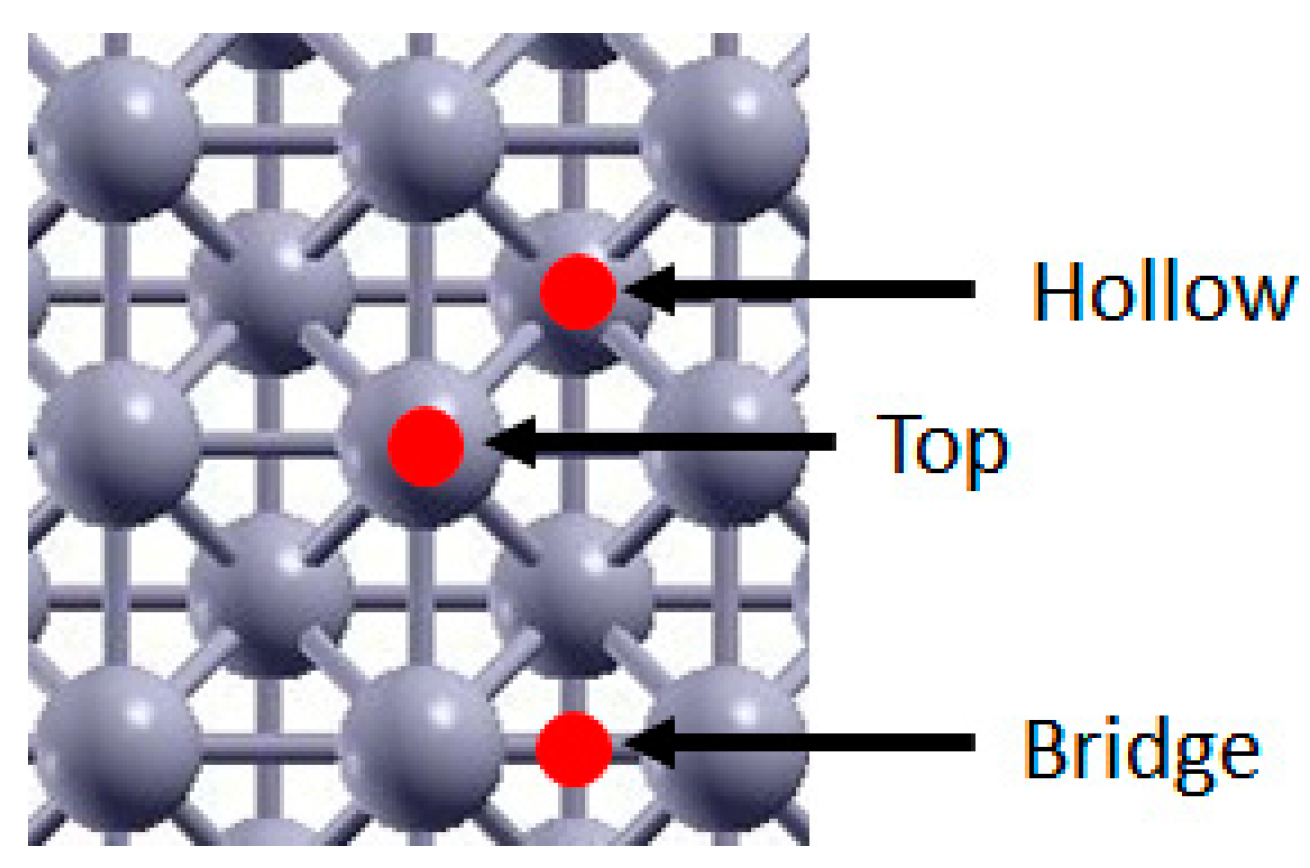

In [11]:
#@title adsorption sites
#@markdown adsorbate가 표면에 달라붙을 때 보통 3가지의 site로 나눔
#@markdown ```python
#@markdown position= ['ontop', 'bridge', 'hollow']
#@markdown ```

from IPython.display import Image, display

!wget -q https://pub.mdpi-res.com/catalysts/catalysts-11-00538/article_deploy/html/images/catalysts-11-00538-g001.png?1619143927 -O site.png

display(Image(filename="./site.png", height=200))


In [42]:
import os
from io import StringIO
from copy import deepcopy
from typing import Callable, Union
import py3Dmol
import numpy as np
import torch
import json
from IPython.display import clear_output
import polars as pl

import ase
from ase.optimize import FIRE
from ase.io import Trajectory, write
from ase.build import make_supercell, add_adsorbate, molecule, surface, fcc100, hcp0001, fcc111
from ase.calculators.calculator import Calculator
from ase.constraints import FixAtoms, FixCartesian
from ase.units import mol, kJ

In [13]:
#@title plot UDFs


def atoms2xyz(atoms:ase.Atoms, wrap=True):
    with StringIO() as buffer:
        if wrap:
            atoms.wrap()
        write(buffer, atoms, format='xyz')
        xyz_string = buffer.getvalue()
    return xyz_string


def plot_atoms(atoms:ase.Atoms, cell_color='red', background_color='white',copy:bool=True , supercell:np.ndarray=None):
    """
    Visualizes a molecular structure from an XYZ format string along with a cell defined by a 3D array in 3D using py3Dmol.

    Parameters:
        atoms (ase.Atoms): ASE Atoms object containing the molecular structure.
        cell_color (str): Color of the cell boundary. Default is 'red'.
        background_color (str): Background color of the viewer. Default is 'white'.

    Returns:
        py3Dmol.view: A 3Dmol.js viewer with the structure and cell.
    """
    # make supercell
    if copy:
        if not supercell:
            supercell = np.array([
                [2, 0, 0],  # 2*x
                [0, 2, 0],  # 2*y
                [0, 0, 1]   # 1*z
                ])
        else:
            assert supercell.shape == (3,3), 'supercell shape is not (3,3)'
        # copy supercell
        atoms = make_supercell(atoms, supercell)

    xyz = atoms2xyz(atoms)
    #assert atoms.cell, 'atoms.cell is empty'
    if not atoms.cell:
        atoms.cell = np.eye(3)
    cell = atoms.cell

    view = py3Dmol.view()
    view.addModel(xyz, 'xyz')

    # Compute cell boundaries based on the cell array
    origin = [0, 0, 0]
    a, b, c = cell
    vertices = [
        origin,           # (0, 0, 0)
        a,                # a
        b,                # b
        c,                # c
        a + b,            # a + b
        a + c,            # a + c
        b + c,            # b + c
        a + b + c         # a + b + c
    ]

    # Convert vertices to the Py3Dmol format
    vertices = [{'x': v[0], 'y': v[1], 'z': v[2]} for v in vertices]

    # Define edges of the cell
    edges = [
        (0, 1), (0, 2), (0, 3),  # From origin
        (1, 4), (1, 5),          # From a
        (2, 4), (2, 6),          # From b
        (3, 5), (3, 6),          # From c
        (4, 7), (5, 7), (6, 7)   # To the farthest corner
    ]

    # Add lines for each edge
    for start, end in edges:
        view.addLine({
            'start': vertices[start],
            'end': vertices[end],
            'color': cell_color
        })

    # Viewer settings
    view.zoomTo()
    view.setBackgroundColor(background_color)
    view.setStyle({'stick': {'radius': 0.2}, 'sphere':{'radius': 0.3}})

    # Show the viewer
    display(view)


def plot_animation(traj:Union[list[ase.Atoms], str], cell_color='red', background_color='white', copy:bool=True , supercell:np.ndarray=None):
    """
    Visualizes a molecular structure from an XYZ format string along with a cell defined by a 3D array in 3D using py3Dmol.

    Parameters:
        traj (list[ase.Atoms]): list of ASE Atoms object containing the molecular structure.
        cell_color (str): Color of the cell boundary. Default is 'red'.
        background_color (str): Background color of the viewer. Default is 'white'.

    Returns:
        py3Dmol.view: A 3Dmol.js viewer with the structure and cell.
    """
    # read it it is traj path
    if isinstance(traj, str):
        if os.path.exists(traj):
            traj = Trajectory(traj)

    # make supercell
    if copy:
        if not supercell:
            supercell = np.array([
                [2, 0, 0],  # 2*x
                [0, 2, 0],  # 2*y
                [0, 0, 1]   # 1*z
                ])
        else:
            assert supercell.shape == (3,3), 'supercell shape is not (3,3)'
        # copy supercell
        traj = [make_supercell(image, supercell) for image in traj]

    traj_str = ''
    for atoms in traj:
        traj_str += atoms2xyz(atoms)

    if not atoms.cell:
        atoms.cell = np.eye(3)
    cell = atoms.cell

    view = py3Dmol.view()
    view.addModelsAsFrames(traj_str,'xyz')

    # Compute cell boundaries based on the cell array
    origin = [0, 0, 0]
    a, b, c = cell
    vertices = [
        origin,           # (0, 0, 0)
        a,                # a
        b,                # b
        c,                # c
        a + b,            # a + b
        a + c,            # a + c
        b + c,            # b + c
        a + b + c         # a + b + c
    ]

    # Convert vertices to the Py3Dmol format
    vertices = [{'x': v[0], 'y': v[1], 'z': v[2]} for v in vertices]

    # Define edges of the cell
    edges = [
        (0, 1), (0, 2), (0, 3),  # From origin
        (1, 4), (1, 5),          # From a
        (2, 4), (2, 6),          # From b
        (3, 5), (3, 6),          # From c
        (4, 7), (5, 7), (6, 7)   # To the farthest corner
    ]

    # Add lines for each edge
    for start, end in edges:
        view.addLine({
            'start': vertices[start],
            'end': vertices[end],
            'color': cell_color
        })

    # Viewer settings
    view.zoomTo()
    view.animate({'loop': "forward"}) # 'duration' in ms / 'reps': 10 --> 'loop': 'forward'
    view.setBackgroundColor(background_color)
    view.setStyle({'stick': {'radius': 0.2}, 'sphere':{'radius': 0.3}})

    # Show the viewer
    display(view)



In [59]:
#@title UDFs


def progress_bar(total, current)->None:
  """
  Description
  -----------
    Display a progress bar indicating the completion status of a task.

  Parameters
  ----------
    - total (int): The total number of units representing the task's completion.
    - current (int): The current progress, representing the number of units completed.

  Example
  -------
  >>> progress_bar(100, 50)
  Processing . . .
    50.0%  |===========>                |  50 / 100
  """
  percent = round(current/total * 100, 2)
  num_progress_bar = round(int(percent) // 5)
  num_redidual_bar =  20 - num_progress_bar
  progress_bar_string = "\033[34mProcessing . . .  \n  {}%  |{}>{}|  {} / {}\033[0m".format(percent, num_progress_bar * "=", num_redidual_bar * " ", current, total)
  print(progress_bar_string)


def z_flip(atoms:ase.Atoms):
    """flip along z-axis"""
    atoms.positions[:, 2] *= -1
    return atoms


'''
In this notebook, each tags label means

- 0              : adsorbate
- 1, 2, .. n ..  : n th layer
'''
def split_system(system:ase.Atoms)->ase.Atoms:
    """split slab and adsorbate
    """
    _slab = deepcopy(system)
    _adsorbate = deepcopy(system)

    # remove constraints before split
    _slab.constraints = None
    _adsorbate.constraints = None

    # remove adsorbates(tags == 0)
    adsorbate_idx = [idx for idx, tag in enumerate(_slab.get_tags()) if tag == 0]
    for idx in sorted(adsorbate_idx, reverse=True):
        del _slab[idx]

    _adsorbate = _adsorbate[adsorbate_idx]
    _adsorbate.pbc = False
    _adsorbate.cell = None
    _adsorbate.center()

    return _slab, _adsorbate


def adsorption_analysis(system:ase.Atoms, calc:Calculator, fmax:float=0.05, id:str=None, sub_calc:Calculator=None):
    """
    get adsorption and interaction energies

    Parameters
    ----------
    system : ase.Atoms
        optimized system with adsorbate

    calc : ase Calculator


    Returns
    -------
    results : dict
    """
    # setup id and path
    if not id:
        # set id to formula if no id passed
        id = system.get_chemical_formula()
    slab_path = f'./{id}_slab.traj'
    adsorbate_path = f'./{id}_adsorbate.traj'
    system_path = f'./{id}_system.traj'

    # optimize system first
    _system = deepcopy(system)
    # pre optimization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing total system ( {system.get_chemical_formula()} )')
        _system.calc = sub_calc
        sys_opt = FIRE(_system)
        assert sys_opt.run(fmax=fmax), 'system optimization failed'
    print(f'Optimizer : optmizing total system ( {system.get_chemical_formula()} )')
    _system.calc = calc
    sys_opt = FIRE(_system, trajectory=system_path)
    assert sys_opt.run(fmax=fmax), 'system optimization failed'

    # split system
    _slab, _adsorbate = split_system(system)

    # get initial energies
    E_system = calc.get_potential_energy(atoms=system)
    E_slab_initial = calc.get_potential_energy(atoms=_slab)
    E_adsorbate_initial = calc.get_potential_energy(atoms=_adsorbate)

    # slab
    # pre optmization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing slab ( {_slab.get_chemical_formula()} )')
        _slab.calc = sub_calc
        slab_opt = FIRE(_slab)
        assert slab_opt.run(fmax=fmax), 'slab  optimization failed'
    print(f'Optimizer : optmizing slab ( {_slab.get_chemical_formula()} )')
    _slab.calc = calc
    slab_opt = FIRE(_slab, trajectory=slab_path)
    assert slab_opt.run(fmax=fmax), 'slab optimization failed'
    E_slab_opt = _slab.get_potential_energy()

    # adsorbate
    # pre optmization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing adsorbate ( {_adsorbate.get_chemical_formula()} )')
        _adsorbate.calc = sub_calc
        adsorbate_opt = FIRE(_adsorbate)
        assert adsorbate_opt.run(fmax=fmax), 'adsorbate  optimization failed'
    print(f'Optimizer : optmizing adsorbate ( {_adsorbate.get_chemical_formula()} )')
    _adsorbate.calc = calc
    adsorbate_opt = FIRE(_adsorbate, trajectory=adsorbate_path)
    assert adsorbate_opt.run(fmax=fmax), 'adsorbate optimization failed'
    E_adsorbate_opt = _adsorbate.get_potential_energy()

    # ads & int energies
    E_ads = E_system - E_slab_opt - E_adsorbate_opt
    E_int = E_system - E_slab_initial - E_adsorbate_initial

    return {
        'E_abs': E_ads,
        'E_int': E_int,
        'path': {
            'system': system_path,
            'slab': slab_path,
            'adsorbate': adsorbate_path
        },
        'id': id,
        'raw_energy':{
            'E_total': E_system,
            'E_slab_opt': E_slab_opt,
            'E_adsorbate_opt': E_adsorbate_opt,
            'E_slab_initial': E_slab_initial,
            'E_adsorbate_initial': E_adsorbate_initial
        }
        }


def ocp_analysis(system:ase.Atoms, calc:Calculator, fmax:float=0.05, id:str=None):
    """
    get adsorption and interaction energies

    Parameters
    ----------
    system : ase.Atoms
        optimized system with adsorbate

    calc : ase Calculator


    Returns
    -------
    results : dict
    """
    # setup id and path
    if not id:
        # set id to formula if no id passed
        id = system.get_chemical_formula()
    slab_path = f'./{id}_slab.traj'
    adsorbate_path = f'./{id}_adsorbate.traj'
    system_path = f'./{id}_system.traj'

    # optimize system first
    _system = deepcopy(system)
    # pre optimization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing total system ( {system.get_chemical_formula()} )')
        _system.calc = sub_calc
        sys_opt = FIRE(_system)
        assert sys_opt.run(fmax=fmax), 'system optimization failed'
    print(f'Optimizer : optmizing total system ( {system.get_chemical_formula()} )')
    _system.calc = calc
    sys_opt = FIRE(_system, trajectory=system_path)
    assert sys_opt.run(fmax=fmax), 'system optimization failed'

    # split system
    _slab, _adsorbate = split_system(system)

    # get initial energies
    E_system = calc.get_potential_energy(atoms=system)
    E_slab_initial = calc.get_potential_energy(atoms=_slab)
    E_adsorbate_initial = calc.get_potential_energy(atoms=_adsorbate)

    # slab
    # pre optmization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing slab ( {_slab.get_chemical_formula()} )')
        _slab.calc = sub_calc
        slab_opt = FIRE(_slab)
        assert slab_opt.run(fmax=fmax), 'slab  optimization failed'
    print(f'Optimizer : optmizing slab ( {_slab.get_chemical_formula()} )')
    _slab.calc = calc
    slab_opt = FIRE(_slab, trajectory=slab_path)
    assert slab_opt.run(fmax=fmax), 'slab optimization failed'
    E_slab_opt = _slab.get_potential_energy()

    # adsorbate
    # pre optmization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing adsorbate ( {_adsorbate.get_chemical_formula()} )')
        _adsorbate.calc = sub_calc
        adsorbate_opt = FIRE(_adsorbate)
        assert adsorbate_opt.run(fmax=fmax), 'adsorbate  optimization failed'
    print(f'Optimizer : optmizing adsorbate ( {_adsorbate.get_chemical_formula()} )')
    _adsorbate.calc = calc
    adsorbate_opt = FIRE(_adsorbate, trajectory=adsorbate_path)
    assert adsorbate_opt.run(fmax=fmax), 'adsorbate optimization failed'
    E_adsorbate_opt = _adsorbate.get_potential_energy()

    # ads & int energies
    E_ads = E_system - E_slab_opt - E_adsorbate_opt
    E_int = E_system - E_slab_initial - E_adsorbate_initial

    return {
        'E_abs': E_ads,
        'E_int': E_int,
        'path': {
            'system': system_path,
            'slab': slab_path,
            'adsorbate': adsorbate_path
        },
        'id': id,
        'raw_energy':{
            'E_total': E_system,
            'E_slab_opt': E_slab_opt,
            'E_adsorbate_opt': E_adsorbate_opt,
            'E_slab_initial': E_slab_initial,
            'E_adsorbate_initial': E_adsorbate_initial
        }
        }


def fix_constraint_by_tags(atoms, tag_value:Union[int, list[int]]=3)->None:
    """
    apply fixatoms constraint by tags value

    Parameters:
        atoms (ase.Atoms): ase atoms
        tag_value (int|list[int]): tags value for applying fix contraint

    """
    tag_values = [tag_value] if isinstance(tag_value, int) else tag_value
    tags = atoms.get_tags()

    # get indices list to fix
    indices_to_fix = []
    indices_to_fix.extend([idx for idx, tag in enumerate(tags) if tag in tag_value])

    # add constraint
    constraint = FixAtoms(indices=indices_to_fix)
    return constraint



def relative_adsorption_analysis(
        ref_system:ase.Atoms, compare_systems:list[ase.Atoms],
        calc:Calculator, fmax:float=0.05, id:str=None,
        sub_calc:Calculator=None, show_system:bool=True
        ):
    """
    get adsorption and interaction energies

    Parameters
    ----------
    system : ase.Atoms
        optimized system with adsorbate

    calc : ase Calculator


    Returns
    -------
    results : dict
    """
    # setup id and path
    # if not id:
    #     # set id to formula if no id passed
    #     id = system.get_chemical_formula()
    # slab_path = f'./{id}_rel_slab.traj'
    # adsorbate_path = f'./{id}_adsorbate.traj'
    # system_path = f'./{id}_system.traj'

    # reference
    # optimize reference system
    print('Analyzing Refence system . . .\n')
    _ref_system = deepcopy(ref_system)
    # pre optmization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing total system ( {_ref_system.get_chemical_formula()} )')
        _ref_system.calc = sub_calc
        sys_opt = FIRE(_ref_system)
        assert sys_opt.run(fmax=fmax), 'system optimization failed'
    print(f'Optimizer : optmizing total system ( {ref_system.get_chemical_formula()} )')
    _ref_system.calc = calc
    sys_opt = FIRE(_ref_system)
    assert sys_opt.run(fmax=fmax), 'system optimization failed'

    # split system
    _ref_slab, _ref_adsorbate = split_system(_ref_system)

    # slab
    # pre optmization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing reference slab ( {_ref_slab.get_chemical_formula()} )')
        _ref_slab.calc = sub_calc
        _ref_slab_opt = FIRE(_ref_slab)
        assert _ref_slab_opt.run(fmax=fmax), 'slab optimization failed'
    # perform optimization
    print(f'Optimizer : optmizing reference slab ( {_ref_slab.get_chemical_formula()} )')
    _ref_slab.calc = calc
    _ref_slab_opt = FIRE(_ref_slab)
    assert _ref_slab_opt.run(fmax=fmax), 'slab optimization failed'
    E_ref_slab_opt = _ref_slab.get_potential_energy()
    if show_system: plot_atoms(_ref_slab)

    # adsorbate
    # pre optmization
    if sub_calc:
        print(f'Sub-Optimizer : optmizing reference adsorbate ( {_ref_adsorbate.get_chemical_formula()} )')
        _ref_adsorbate.calc = sub_calc
        _ref_adsorbate_opt = FIRE(_ref_adsorbate)
        assert _ref_adsorbate_opt.run(fmax=fmax), 'adsorbate optimization failed'
    print(f'Optimizer : optmizing reference adsorbate ( {_ref_adsorbate.get_chemical_formula()} )')
    _ref_adsorbate.calc = calc
    _ref_adsorbate_opt = FIRE(_ref_adsorbate)
    assert _ref_adsorbate_opt.run(fmax=fmax), 'adsorbate optimization failed'
    E_ref_adsorbate_opt = _ref_adsorbate.get_potential_energy()
    if show_system: plot_atoms(_ref_adsorbate)

    E_ref = E_ref_slab_opt * len(compare_systems) + E_ref_adsorbate_opt

    # system to compare

    print('Analyzing systems to compare . . .\n')
    E_systems = []
    for idx, system in enumerate(compare_systems):
        _system = deepcopy(system)

        # pre optmization
        if sub_calc:
            print(f'Sub-Optimizer : optimizing system idx : {idx} ( {_system.get_chemical_formula()} )')
            _system.calc = sub_calc
            sys_opt = FIRE(_system)
            assert sys_opt.run(fmax=fmax), 'adsorbate optimization failed'

        # main optimization
        print(f'Optimizer : optimizing system idx : {idx} ( {_system.get_chemical_formula()} )')
        _system.calc = calc
        sys_opt = FIRE(_system)
        assert sys_opt.run(fmax=fmax), 'system optimization failed'
        E_systems.append(_system.get_potential_energy())
        if show_system: plot_atoms(_system)

    E_systems_sum = sum(E_systems)

    E_rel = E_systems_sum - E_ref

    return {
        'E_rel': E_rel,
        'E_ref': E_ref,
        'E_systems': E_systems,
        'E_ref_slab_opt': E_ref_slab_opt,
        'E_ref_adsorbate_opt': E_ref_adsorbate_opt,
        'N_systems': len(compare_systems)
        }

def nitrogen_constraint(atoms:ase.Atoms):
    """fix nitrongen atoms along xy direction"""
    N_indices = [i for i, atom in enumerate(atoms) if atom.symbol == 'N']

    constraint = FixCartesian(a=N_indices, mask=[True, True, False])

    return constraint

def create_system(
        metal:str, miller:str, shape:str,
        site:str, size=(3,3,4), vacuum=10.0,
        fixlayer:list=[3,4], height=2.0,
        flip:bool=True, ads_name:str='NH3'
        ):
    """
    create initial system

    site : str
        adsorbption site e.g. 'ontop'
    metal : str
        metal symbols e.g. 'Pt', 'Pd', 'Rh'
    shape : str
        slab shape e.g. 'fcc', 'hcp'
    miller : str
        miller index e.g. '100', '0001'
    size : tuple
        slab size e.g. (3, 3, 4)
    fixlayer : list
        tags to fix e.g. [3, 4]
    vacuum : float
        vacuum heigh e.g. 10
    height : float
        adsorbate height from the top surface layer e.g. 2
    flip : bool
        flip adsorbate along z-axis e.g. True
    ads_name : str
        adsorbate name e.g. 'H20', 'NH3'
    """

    assert site in ['ontop', 'bridge', 'hollow', 'fcc', 'hcp'], f'unavailable site : {site}'
    assert miller in ['100', '0001' ,'111'], f'unavailable miller index : {miller}'
    assert metal in ['Pt', 'Pd', 'Rh'], f'unavailable metal atom : {metal}'
    assert shape in ['fcc', 'hcp'], f'unavailable shape : {shape}'

    if miller == '100' and shape == 'fcc':
        slab_ftn = fcc100
    #elif miller == '0001' and shape == 'hcp':
    #    slab_ftn = hcp0001
    elif miller == '111' and shape == 'fcc':
        slab_ftn = fcc111
    else:
        raise NotImplementedError

    slab = slab_ftn(metal, size=size, vacuum=vacuum, periodic=True)
    ads = molecule(ads_name)
    if flip:
        z_flip(ads)

    # locate adsorbate into slab
    add_adsorbate(slab, ads, height=height, position=site)

    # apply constraints
    constraints = []
    constraints.append(fix_constraint_by_tags(slab, fixlayer))
    constraints.append(nitrogen_constraint(slab))

    slab.set_constraint(constraints)

    return slab

In [60]:
sites = ['ontop', 'bridge', 'hollow', 'fcc', 'hcp']
metals = ['Pt', 'Pd', 'Rh']
shapes = ['fcc']
millers = ['100', '111']

from itertools import product

systems = {}
for site, metal, shape, miller in product(sites, metals, shapes, millers):
    try:
        system = create_system(
        metal=metal,
        site=site,
        miller=miller,
        shape=shape
        )
        #key = '_'.join([metal, shape, miller, site])
        key = f'{metal}_{shape}({miller})_{site}'
        systems[key] = system
    except Exception as e:
        print(e)
        pass

Adsorption site hollow not supported.
Adsorption site hollow not supported.
Adsorption site hollow not supported.
Adsorption site fcc not supported.
Adsorption site fcc not supported.
Adsorption site fcc not supported.
Adsorption site hcp not supported.
Adsorption site hcp not supported.
Adsorption site hcp not supported.


In [61]:
for key in systems.keys():
    print(key)

Pt_fcc(100)_ontop
Pt_fcc(111)_ontop
Pd_fcc(100)_ontop
Pd_fcc(111)_ontop
Rh_fcc(100)_ontop
Rh_fcc(111)_ontop
Pt_fcc(100)_bridge
Pt_fcc(111)_bridge
Pd_fcc(100)_bridge
Pd_fcc(111)_bridge
Rh_fcc(100)_bridge
Rh_fcc(111)_bridge
Pt_fcc(100)_hollow
Pd_fcc(100)_hollow
Rh_fcc(100)_hollow
Pt_fcc(111)_fcc
Pd_fcc(111)_fcc
Rh_fcc(111)_fcc
Pt_fcc(111)_hcp
Pd_fcc(111)_hcp
Rh_fcc(111)_hcp


In [62]:
eV2kJpermol = 1 / kJ * mol

In [63]:

os.makedirs('./results', exist_ok=True)

E_ads_kJpermol_container = []
metal_container = []
site_container = []
surface_container = []

total_num = len(systems)

for idx, (key, system) in enumerate(systems.items()):
    progress_bar(total_num, idx+1)
    result_dict = adsorption_analysis(
        system=system,
        calc=calc_dict['mace_osaka'],
        fmax=0.05,
        id=key
    )
    E_ads_kJpermol = result_dict['E_abs'] * eV2kJpermol

    # calc info
    key_split = key.split('_')
    metal = key_split[0]
    surface = key_split[1]
    site = key_split[2]

    metal_container.append(metal)
    site_container.append(site)
    surface_container.append(surface)
    E_ads_kJpermol_container.append(E_ads_kJpermol)

   # save result
    with open(f'./results/{key}.json', 'w') as json_file:
        json.dump(result_dict, json_file, indent=4, ensure_ascii=False)

    clear_output()

In [65]:

import polars as pl

data = {
    "metal": metal_container,
    "site": site_container,
    "surface": surface_container,
    "E_ads_kJpermol": E_ads_kJpermol_container
}

summary = pl.DataFrame(data)

summary

metal,site,surface,E_ads_kJpermol
str,str,str,f64
"""Pt""","""ontop""","""fcc(100)""",-20.75793
"""Pt""","""ontop""","""fcc(111)""",13.882123
"""Pd""","""ontop""","""fcc(100)""",-33.189816
"""Pd""","""ontop""","""fcc(111)""",-26.68012


In [66]:
summary.write_csv(f"summary_{model}.csv")

In [64]:
import glob

system_traj = glob.glob('./*_system.traj')
for traj in system_traj:
    last = Trajectory(traj)[-1]
    print(traj)
    plot_atoms(last)

./Pt_fcc(111)_ontop_system.traj


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

./Pt_fcc(100)_ontop_system.traj


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

./Pd_fcc(111)_ontop_system.traj


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

./Pd_fcc(100)_ontop_system.traj


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### trash

In [9]:
# build system

NH3 = molecule('NH3')
NH2 = molecule('NH3')[:3]
z_flip(NH3)
z_flip(NH2)

H = ase.Atoms('H', positions=[[0, 0, 0]])

slab_110_NH3 = fcc100('Pt', size=(3, 3, 4), vacuum=10.0, periodic=True)

slab_110_NH2 = fcc100('Pt', size=(3, 3, 4), vacuum=10.0, periodic=True)

slab_110_H = fcc100('Pt', size=(3, 3, 4), vacuum=10.0, periodic=True)

add_adsorbate(slab_110_NH3, NH3, height=2.0, position='ontop', )
add_adsorbate(slab_110_NH2, NH2, height=2.0, position='ontop', )
add_adsorbate(slab_110_H, H, height=2.0, position='ontop', )

fix_constraint_by_tags(slab_110_NH3, [3, 4])
fix_constraint_by_tags(slab_110_NH2, [3, 4])
fix_constraint_by_tags(slab_110_H, [3, 4])

In [ ]:
ads_results = adsorption_analysis(
    system=slab_110_NH3,
    calc=calc_dict['orb'],
    #sub_calc=calc_dict['orb'],
    fmax=0.05
)

In [13]:
ads_results

{'E_abs': -0.81182861328125,
 'E_int': -0.7853813171386719,
 'path': {'system': './H3NPt36_system.traj',
  'slab': './H3NPt36_slab.traj',
  'adsorbate': './H3NPt36_adsorbate.traj'},
 'id': 'H3NPt36',
 'raw_energy': {'E_total': -243.03372192382812,
  'E_slab_opt': -222.721435546875,
  'E_adsorbate_opt': -19.500457763671875,
  'E_slab_initial': -222.7801513671875,
  'E_adsorbate_initial': -19.468189239501953}}

In [ ]:
rel_results = relative_adsorption_analysis(
    ref_system=slab_110_NH3,
    compare_systems=[
        slab_110_NH2, slab_110_H
        ],
    calc=calc_dict['orb'],
    #sub_calc=calc_dict['orb'],
    fmax=0.05
    )

In [15]:
rel_results

{'E_rel': 0.2952919006347656,
 'E_ref': -464.9547920227051,
 'E_systems': [-238.27468872070312, -226.3848114013672],
 'E_ref_slab_opt': -222.73089599609375,
 'E_ref_adsorbate_opt': -19.493000030517578,
 'N_systems': 2}

In [16]:
from ase.units import mol, kJ

1 / kJ * mol

96.48533288249877

In [ ]:
#slab_111 = fcc111('Pt', size=(3, 3, 4), vacuum=10.0, periodic=True)
slab_110 = bcc100('Fe', size=(3, 3, 4), vacuum=10.0, periodic=True)


#H2O = molecule('H2O')
NH3 = molecule('NH3')

# supercell_matrix = np.array([[2, 0, 0],
#                              [0, 2, 0],
#                              [0, 0, 1]])

#slab_111_4 = make_supercell(slab_111, supercell_matrix)

#z_flip(H2O)
z_flip(NH3)

add_adsorbate(slab_110, NH3, height=2.0, position='ontop', )

fix_constraint_by_tags(slab_110, [3, 4])
#add_adsorbate(slab_110, NH3, height=1.0, position='ontop', )

plot_atoms(slab_110)

In [ ]:
slab_110 = bcc100('Fe', size=(3, 3, 3), vacuum=10.0, periodic=True)

NH2 = molecule('NH3')[:3]
NH2.center()

H = molecule('H2')[:1]

z_flip(NH2)

add_adsorbate(slab_110, NH2, height=1.0, position='bridge', )
add_adsorbate(slab_110, H, height=1.0, position='hollow', offset=(0, -1))

<br>
<br>
<br>
<br>
<br>
below cell for backup
<br>
<br>
<br>

In [ ]:
#@title deprecated

import plotly.colors as pc
import plotly.graph_objects as go
from itertools import cycle
import numpy as np
#from asedias.data import atomic_number2element_symbol, covalent_radii, atomic_symbols2hex
from scipy.spatial.distance import pdist, squareform
import warnings
from typing import Union

covalent_radii = {
'H':  0.31, 'He': 0.28, 'Li': 1.28, 'Be': 0.96, 'B':  0.84, 'C':  0.76,
'N':  0.71, 'O':  0.66, 'F':  0.57, 'Ne': 0.58, 'Na': 1.66, 'Mg': 1.41,
'Al': 1.21, 'Si': 1.11, 'P':  1.07, 'S':  1.05, 'Cl': 1.02, 'Ar': 1.06,
'K':  2.03, 'Ca': 1.76, 'Sc': 1.70, 'Ti': 1.60, 'V':  1.53, 'Cr': 1.39,
'Mn': 1.61, 'Fe': 1.52, 'Co': 1.50, 'Ni': 1.24, 'Cu': 1.32, 'Zn': 1.22,
'Ga': 1.22, 'Ge': 1.20, 'As': 1.19, 'Se': 1.20, 'Br': 1.20, 'Kr': 1.16,
'Rb': 2.20, 'Sr': 1.95, 'Y':  1.90, 'Zr': 1.75, 'Nb': 1.64, 'Mo': 1.54,
'Tc': 1.47, 'Ru': 1.46, 'Rh': 1.42, 'Pd': 1.39, 'Ag': 1.45, 'Cd': 1.44,
'In': 1.42, 'Sn': 1.39, 'Sb': 1.39, 'Te': 1.38, 'I':  1.39, 'Xe': 1.40,
'Cs': 2.44, 'Ba': 2.15, 'La': 2.07, 'Ce': 2.04, 'Pr': 2.03, 'Nd': 2.01,
'Pm': 1.99, 'Sm': 1.98, 'Eu': 1.98, 'Gd': 1.96, 'Tb': 1.94, 'Dy': 1.92,
'Ho': 1.92, 'Er': 1.89, 'Tm': 1.90, 'Yb': 1.87, 'Lu': 1.87, 'Hf': 1.75,
'Ta': 1.70, 'W':  1.62, 'Re': 1.51, 'Os': 1.44, 'Ir': 1.41, 'Pt': 1.36,
'Au': 1.36, 'Hg': 1.32, 'Tl': 1.45, 'Pb': 1.46, 'Bi': 1.48, 'Po': 1.40,
'At': 1.50, 'Rn': 1.50, 'Fr': 2.60, 'Ra': 2.21, 'Ac': 2.15, 'Th': 2.06,
'Pa': 2.00, 'U':  1.96, 'Np': 1.90, 'Pu': 1.87, 'Am': 1.80, 'Cm': 1.69
}

# Periodic Table
# Ref. https://github.com/dralgroup/mlatom/blob/main/mlatom/data.py
periodic_table = """X
    H                                                                                                                           He
    Li  Be                                                                                                  B   C   N   O   F   Ne
    Na  Mg                                                                                                  Al  Si  P   S   Cl  Ar
    K   Ca  Sc                                                          Ti  V   Cr  Mn  Fe  Co  Ni  Cu  Zn  Ga  Ge  As  Se  Br  Kr
    Rb  Sr  Y                                                           Zr  Nb  Mo  Tc  Ru  Rh  Pd  Ag  Cd  In  Sn  Sb  Te  I   Xe
    Cs  Ba  La  Ce  Pr  Nd  Pm  Sm  Eu  Gd  Tb  Dy  Ho  Er  Tm  Yb  Lu  Hf  Ta  W   Re  Os  Ir  Pt  Au  Hg  Tl  Pb  Bi  Po  At  Rn
    Fr  Ra  Ac  Th  Pa  U   Np  Pu  Am  Cm
""".strip().split()

atomic_number2element_symbol = {k: v for k, v in enumerate(periodic_table)}
element_symbol2atomic_number = {v: k for k, v in atomic_number2element_symbol.items()}


# Jmol CPK coloring
# Ref. https://jmol.sourceforge.net/jscolors/
atomic_symbols2hex = {
'H': '#FFFFFF',   'He': '#D9FFFF',    'Li': '#CC80FF',  'Be': '#C2FF00',
'B': '#FFB5B5',   'C': '#909090',     'N': '#3050F8',   'O': '#FF0D0D',
'F': '#90E050',   'Ne': '#B3E3F5',    'Na': '#AB5CF2',  'Mg': '#8AFF00',
'Al': '#BFA6A6',  'Si': '#F0C8A0',    'P': '#FF8000',   'S': '#FFFF30',
'Cl': '#1FF01F',  'Ar': '#80D1E3',    'K': '#8F40D4',   'Ca': '#3DFF00',
'Sc': '#E6E6E6',  'Ti': '#BFC2C7',    'V': '#A6A6AB',   'Cr': '#8A99C7',
'Mn': '#9C7AC7',  'Fe': '#E06633',    'Co': '#F090A0',  'Ni': '#50D050',
'Cu': '#C88033',  'Zn': '#7D80B0',    'Ga': '#C28F8F',  'Ge': '#668F8F',
'As': '#BD80E3',  'Se': '#FFA100',    'Br': '#A62929',  'Kr': '#5CB8D1',
'Rb': '#702EB0',  'Sr': '#00FF00',    'Y': '#94FFFF',   'Zr': '#94E0E0',
'Nb': '#73C2C9',  'Mo': '#54B5B5',    'Tc': '#3B9E9E',  'Ru': '#248F8F',
'Rh': '#0A7D8C',  'Pd': '#006985',    'Ag': '#C0C0C0',  'Cd': '#FFD98F',
'In': '#A67573',  'Sn': '#668080',    'Sb': '#9E63B5',  'Te': '#D47A00',
'I': '#940094',   'Xe': '#429EB0',    'Cs': '#57178F',  'Ba': '#00C900',
'La': '#70D4FF',  'Ce': '#FFFFC7',    'Pr': '#D9FFC7',  'Nd': '#C7FFC7',
'Pm': '#A3FFC7',  'Sm': '#8FFFC7',    'Eu': '#61FFC7',  'Gd': '#45FFC7',
'Tb': '#30FFC7',  'Dy': '#1FFFC7',    'Ho': '#00FF9C',  'Er': '#00E675',
'Tm': '#00D452',  'Yb': '#00BF38',    'Lu': '#00AB24',  'Hf': '#4DC2FF',
'Ta': '#4DA6FF',  'W': '#2194D6',     'Re': '#267DAB',  'Os': '#266696',
'Ir': '#175487',  'Pt': '#D0D0E0',    'Au': '#FFD123',  'Hg': '#B8B8D0',
'Tl': '#A6544D',  'Pb': '#575961',    'Bi': '#9E4FB5',  'Po': '#AB5C00',
'At': '#754F45',  'Rn': '#428296',    'Fr': '#420066',  'Ra': '#007D00',
'Ac': '#70ABFA',  'Th': '#00BAFF',    'Pa': '#00A1FF',  'U': '#008FFF',
'Np': '#0080FF',  'Pu': '#006BFF',    'Am': '#545CF2',  'Cm': '#785CE3'
}

atomic_number2hex = {element_symbol2atomic_number[symbol]: rgb for symbol, rgb in atomic_symbols2hex.items()}

def animation(images:list[ase.Atoms], frag_indices:list=None, colorby:str="fragment",
                   cmap:str=None, covalent_radius_percent:float=108., **kwargs):
    """
    Visualization of molecular structures in 3D using Plotly.

    Parameters
    ----------


    Additional Keyword Arguments
    ----------------------------
    - alpha_atoms : float
        Opacity of atoms. Default: 0.55
    - alpha_bonds : float
        Opacity of bonds. Default: 0.55
    - atom_scaler : float
        Scaling factor for atom visualization. Default: 20
    - bond_scaler : float
        Scaling factor for bond visualization. Default: 10,000
    - legend : bool
        Show legend in the visualization. Default: True
    - scale_box : bool
        Show scale box in the visualization. Default: True
    - unit_bar : bool
        Show unit bar in the visualization. Default: True
    - camera_projection : str
        ['orthographic', 'perspective'] Defaut: 'orthographic'
    - template : str
        ['plotly', 'plotly_dark', etc. ] Defaut: 'plotly_dark'

    Returns
    -------
    None. Displays a 3D interactive visualization.

    """
    def _get_pallete_colors(cmap: str | list, n: int):
        """Generate a list of n colors from a Plotly colormap or a custom color list."""
        if not cmap:
            cmap = 'Plotly3'
        try:
            pc.get_colorscale(cmap)
        except Exception:
            print("\033[31m[WARNING]\033[0m", f"'{cmap}' is not a valid Plotly colormap. Defaulting to 'Plotly3'.")
            cmap = 'Plotly3'

        if isinstance(cmap, str):
            colors = pc.get_colorscale(cmap)
            return list(pc.sample_colorscale(colors, [ratio for ratio in np.linspace(0, 1, n + 1)[1:]], colortype='rgb'))
        elif isinstance(cmap, list):
            cyclic_iterator = cycle(cmap)
            return [next(cyclic_iterator) for _ in range(n)]

    def _get_frag_color(frag_indices:list):
        """

        """
        colors = [
            "#FF5733", "#33FF57", "#3357FF", "#F5A623", "#8E44AD",
            "#2ECC71", "#F39C12", "#1F618D", "#F1948A", "#7D3C98"
            ]
        frag_colors = colors[:len(frag_indices)]
        return frag_colors

    def _plot_scale_box(box_half_length:float, unit_bar:bool=True):
        """
        plot scale box
        """
        hl = box_half_length # box half-length

        # Box vertices
        x_coords = [-hl, hl, hl, -hl, -hl, hl, hl, -hl]
        y_coords = [-hl, -hl, hl, hl, -hl, -hl, hl, hl]
        z_coords = [-hl, -hl, -hl, -hl, hl, hl, hl, hl]

        # Define edges by vertex indices
        edges = [
            (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face edges
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top face edges
            (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
            ]

        x_box_lines = []
        y_box_lines = []
        z_box_lines = []

        for edge in edges:
            for vertex in edge:
                x_box_lines.append(x_coords[vertex])
                y_box_lines.append(y_coords[vertex])
                z_box_lines.append(z_coords[vertex])
            x_box_lines.append(None)
            y_box_lines.append(None)
            z_box_lines.append(None)

        box_plots = [
            # scaling bar
            go.Scatter3d(
                x=[hl, hl],
                y=[-hl, -hl+1],
                z=[-hl, -hl],
                mode='lines+text',
                line=dict(color='red', width=13),
                text=['1 Å'],
                textposition='top center',
                textfont=dict(size=12, color='red'),
                showlegend=False,
                name=f'Bar',
                legendgroup=f'Box',
                hoverinfo='text',
                hovertext=f'Bar'
            ) if unit_bar else go.Scatter3d(
                x=[hl, hl],
                y=[-hl, +hl],
                z=[-hl, -hl],
                mode='lines+text',
                line=dict(color='red', width=13),
                text=[f'{np.round(hl*2, 1)} Å'],
                textposition='top center',
                textfont=dict(size=12, color='red'),
                showlegend=False,
                name=f'Bar',
                legendgroup=f'Box',
                hoverinfo='text',
                hovertext=f'Bar'
                ),
            # box lines
            go.Scatter3d(
                x=x_box_lines,
                y=y_box_lines,
                z=z_box_lines,
                mode='lines',
                line=dict(color='grey', width=4),
                showlegend=True,
                name=f'Box',
                legendgroup=f'Box',
                hoverinfo='text',
                hovertext=f'Box'
            )
            ]
        return box_plots

    # Default visualization parameters
    alpha_atoms = kwargs.get("alpha_atoms", 1)
    alpha_bonds = kwargs.get("alpha_bonds", 0.7)
    atom_scaler = kwargs.get("atom_scaler", 300)
    bond_scaler = kwargs.get("bond_scaler", 8200000)
    scale_box = kwargs.get("scale_box", True)
    legend = kwargs.get("legend", True)
    unit_bar = kwargs.get("unit_bar", True)
    camera_projection = kwargs.get("camera_projection", "orthographic")
    template = kwargs.get("template", "plotly_dark")

    # Make sure each position is centered
    for atoms in images:
        atoms.center()

    # Calculate global ranges for all molecular structures
    all_positions = np.vstack([atoms.positions for atoms in images])
    range_array = np.vstack([[np.min(all_positions[:, i]) for i in range(3)], [np.max(all_positions[:, i]) for i in range(3)]])
    x_range, y_range, z_range = range_array[:, 0], range_array[:, 1], range_array[:, 2]
    padding = 0.1
    if scale_box:
        half_box_length = np.max(np.abs(range_array)) * 1.3
        max_range = [- half_box_length - padding, half_box_length + padding]
    x_range = [x_range[0] - padding, x_range[1] + padding]
    y_range = [y_range[0] - padding, y_range[1] + padding]
    z_range = [z_range[0] - padding, z_range[1] + padding]

    frames = []

    if colorby == "molecule":
        num_of_atoms = max(len(atoms) for atoms in images)
        num_of_molecules = len(images)
        palette = _get_pallete_colors(cmap, num_of_molecules)

        for mol_idx, atoms in enumerate(images):
            frame_data = []
            color = palette[mol_idx]

            # Add atoms
            atom_size = max(np.log10(atom_scaler / num_of_atoms) * 5, 2)
            frame_data.append(go.Scatter3d(
                x=atoms.positions[:, 0],
                y=atoms.positions[:, 1],
                z=atoms.positions[:, 2],
                mode='markers',
                opacity=alpha_atoms,
                marker=dict(size=atom_size, color=color),
                name=f'Molecule {mol_idx + 1} atoms'
            ))

            # Add bonds
            bond_thickness = np.maximum(np.log10(bond_scaler / num_of_atoms) * 2, 1) # bond thickness
            bond_x, bond_y, bond_z = [], [], []
            for i, pos1 in enumerate(atoms.positions):
                for j, pos2 in enumerate(atoms.positions[i + 1:], start=i+1):
                    dist = np.linalg.norm(pos1 - pos2)
                    radius_sum = covalent_radii[atomic_number2element_symbol[atoms.numbers[i]]] + covalent_radii[atomic_number2element_symbol[atoms.numbers[j]]]
                    if dist <= radius_sum * covalent_radius_percent / 100:
                        bond_x.extend([pos1[0], pos2[0], None])
                        bond_y.extend([pos1[1], pos2[1], None])
                        bond_z.extend([pos1[2], pos2[2], None])
            frame_data.append(go.Scatter3d(
                x=bond_x, y=bond_y, z=bond_z,
                mode='lines',
                opacity=alpha_bonds,
                line=dict(width=bond_thickness, color=color),
                name=f'Molecule {mol_idx + 1} bonds'
            ))

            # add scale_box plots if scale_box == True
            if scale_box:
                frame_data.extend(
                    _plot_scale_box(box_half_length=half_box_length, unit_bar=unit_bar)
                    )

            frames.append(go.Frame(data=frame_data, name=str(mol_idx)))

    elif colorby == "fragment":
        num_of_atoms = max(len(atoms) for atoms in images)
        num_of_molecules = len(images)
        frag_colors = _get_frag_color(frag_indices=frag_indices)
        atom_size = max(np.log10(atom_scaler / num_of_atoms) * 5, 2)
        for mol_idx, atoms in enumerate(images):
            frame_data = []
            for frag_idx, (atomic_indices, frag_color) in enumerate(zip(frag_indices, frag_colors)):
                frag_atoms = atoms[atomic_indices]

                # Add atoms
                frame_data.append(go.Scatter3d(
                    x=frag_atoms.positions[:, 0],
                    y=frag_atoms.positions[:, 1],
                    z=frag_atoms.positions[:, 2],
                    mode='markers',
                    opacity=alpha_atoms,
                    marker=dict(size=atom_size, color=frag_color),
                    name=f'Fragment {frag_idx + 1}',
                    legendgroup=f'Fragment {frag_idx + 1}',
                    showlegend=True,
                    hoverinfo='text',
                    hovertext=f'Fragment {frag_idx + 1}'
                ))

                # Add bonds
                bond_x, bond_y, bond_z = [], [], []
                bond_thickness = np.maximum(np.log10(bond_scaler / num_of_atoms) * 2, 1) # bond thickness
                for i, pos1 in enumerate(frag_atoms.positions):
                    for j, pos2 in enumerate(frag_atoms.positions[i + 1:], start=i+1):
                        dist = np.linalg.norm(pos1 - pos2)
                        radius_sum = covalent_radii[atomic_number2element_symbol[frag_atoms.numbers[i]]] + covalent_radii[atomic_number2element_symbol[frag_atoms.numbers[j]]]
                        if dist <= radius_sum * covalent_radius_percent / 100:
                            bond_x.extend([pos1[0], pos2[0], None])
                            bond_y.extend([pos1[1], pos2[1], None])
                            bond_z.extend([pos1[2], pos2[2], None])
                frame_data.append(go.Scatter3d(
                    x=bond_x, y=bond_y, z=bond_z,
                    mode='lines',
                    opacity=alpha_bonds,
                    line=dict(width=bond_thickness, color=frag_color),
                    name=f'Fragment {frag_idx + 1}',
                    showlegend=False,
                    legendgroup=f'Fragment {frag_idx + 1}',
                    hoverinfo='text',
                    hovertext=f'Fragment {frag_idx + 1}'
                ))

            # add scale_box plots if scale_box == True
            if scale_box:
                frame_data.extend(
                    _plot_scale_box(box_half_length=half_box_length, unit_bar=unit_bar)
                    )

            frames.append(go.Frame(data=frame_data, name=str(mol_idx)))


    # Create the figure
    fig = go.Figure()
    fig.add_traces(frames[0].data)

    # Update the layout and add animation controls
    fig.frames = frames
    fig.update_layout(
        width=800, height=600,
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 30, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 10, 'easing': 'quadratic-in-out'}}],
                    'label': 'Play',
                    'method': 'animate',
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate',
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Frame: ',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 300, 'easing': 'cubic-in-out'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [
                {'args': [[f.name], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                 'label': str(k),
                 'method': 'animate'} for k, f in enumerate(fig.frames)
            ]
        }],
        scene=dict(
            xaxis=dict(range=max_range if scale_box else x_range, visible=False),
            yaxis=dict(range=max_range if scale_box else y_range, visible=False),
            zaxis=dict(range=max_range if scale_box else z_range, visible=False),
            aspectmode='manual',
            camera_projection=dict(type=camera_projection), # orthograpic perspective
            aspectratio=dict(x=1, y=1, z=1),
        ),
        showlegend=True if legend else False,
        template=template,
    )

    fig.show()



sla = [i for i in range(27)]
ads = [27, 28, 29, 30]

traj = Trajectory('/content/H3Fe27N_system.traj')

animation(traj, frag_indices=[sla, ads])

In [ ]:
#@title load calcaulator

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if model == 'orb':
    from orb_models.forcefield import pretrained
    from orb_models.forcefield.calculator import ORBCalculator

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    orbff = pretrained.orb_d3_v2(device=device, )
    calc_orb = ORBCalculator(orbff, device=device, )
    calc_dict = {
        'orb': calc_orb,
    }

elif model == 'mace':
    from mace.calculators import mace_mp
    from mace.calculators import MACECalculator

    osaka_path = './mace_osaka.pt'
    mace_mpa = "./mace_mpa_0.pt"

    calc_mace_mp = mace_mp(model="large", dispersion=True, default_dtype="float64", device=device,)
    calc_mace_mpa = mace_mp(model=mace_mpa, dispersion=True, default_dtype="float64", device=device)
    calc_osaka = MACECalculator(model_path=osaka_path, default_dtype="float64", device=device, )
    calc_dict = {
        'mace_mp': calc_mace_mp,
        'mace_mpa': calc_mace_mpa,
        'mace_osaka': calc_osaka,
    }
elif model == 'mattersim':
    from mattersim.forcefield import MatterSimCalculator

    mattersim_path = './mattersim_5M.pt'
    calc_mattersim = MatterSimCalculator(load_path=mattersim_path, device=device)
    calc_dict = {
        'mattersim': calc_mattersim,
    }
elif model == 'seven':
    from sevenn.sevennet_calculator import SevenNetCalculator

    calc_seven = SevenNetCalculator(model='7net-l3i5', device=device)
    calc_dict = {
        'seven': calc_seven,
    }

In [ ]:
# mace large mace_mp
from mace.calculators import mace_mp

device = 'cuda' if torch.cuda.is_available() else 'cpu'
calc_mace_mp = mace_mp(model="large", dispersion=True, default_dtype="float64", device=device,)

Using Materials Project MACE for MACECalculator with /root/.cache/mace/MACE_MPtrj_20229model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections


In [ ]:
# mace mpa_0 / more advanced model
from mace.calculators import mace_mp

device = 'cuda' if torch.cuda.is_available() else 'cpu'
calc_mace_mpa = mace_mp(model="./mace_mpa_0.pt", dispersion=True, default_dtype="float64", device=device)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections


In [ ]:
# orb model
from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator

device = 'cuda' if torch.cuda.is_available() else 'cpu'
orbff = pretrained.orb_d3_v2(device=device, )
calc_orb = ORBCalculator(orbff, device=device, )

/usr/local/lib/python3.10/dist-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(local_path, map_locatio

In [ ]:
# mace osaka
from mace.calculators import MACECalculator

osaka_path = './mace_osaka.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
calc_osaka = MACECalculator(model_path=osaka_path, device=device, default_dtype="float64")

/usr/local/lib/python3.10/dist-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


In [ ]:
from mattersim.forcefield import MatterSimCalculator

device = "cuda" if torch.cuda.is_available() else "cpu"
mattersim_path = './mattersim_5M.pt'
calc_mattersim = MatterSimCalculator(load_path=mattersim_path, device=device)

2025-01-14 10:24:50.383 | INFO     | mattersim.forcefield.potential:from_checkpoint:893 - Loading the model from ./mattersim_5M.pt


/usr/local/lib/python3.10/dist-packages/mattersim/forcefield/potential.py:896: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=

In [ ]:
from sevenn.sevennet_calculator import SevenNetCalculator

device = "cuda" if torch.cuda.is_available() else "cpu"
calc_seven = SevenNetCalculator(model='7net-l3i5', device=device)